## Conversion Rate

### Import Package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree
import graphviz

### Read Data

In [29]:
data = pd.read_csv('conversion_data.csv')
data_origin = data.copy()

In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
data.shape

(316200, 6)

### Exploratory Data Analysis

Main Take Away:

1. Most users come from the U.S.
2. Most users are new shoppers, not returning users.
3. Users are mostly drawn by SEO.
4. The common age range of users is 20-40, and the common total page visited is about 3.
5. The conversion rate is about 3%. Most of the records are unconverted cases.
6. Conversion rate is highly correlated with total pages visited.

In [5]:
average_convert_rate = round(data['converted'].sum()/data.shape[0],2)
print('Conversion rate is ',average_convert_rate)

Conversion rate is  0.03


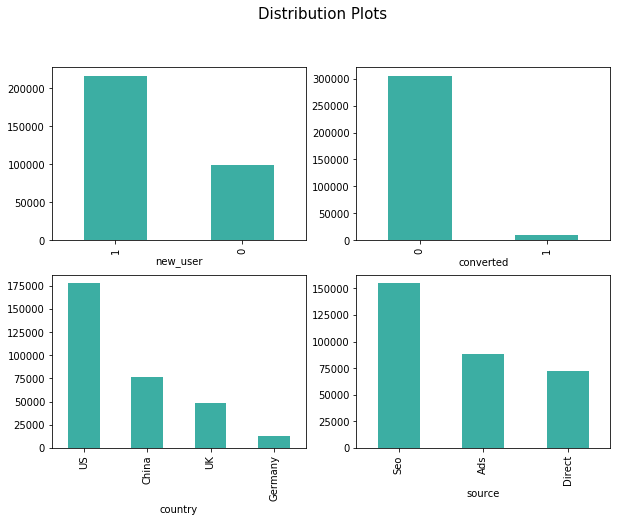

In [6]:
plt.subplots(figsize=(10,7))
i = 1
for y in ['new_user','converted','country','source']:
    plt.subplot(2, 2, i)
    data[y].value_counts().plot('bar', color = '#3CAEA3')
    plt.xlabel(y)
    i = i + 1
plt.suptitle('Distribution Plots',fontsize=15,y=1)
plt.show()

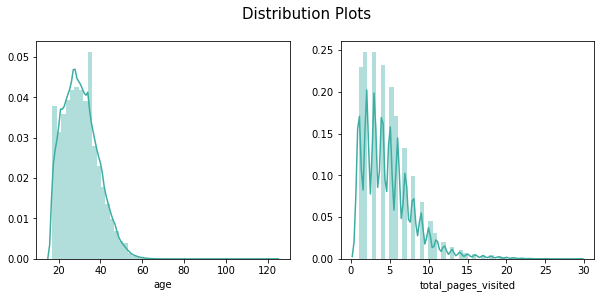

In [7]:
plt.subplots(figsize=(10,4)) 
i=1   
for y in ['age','total_pages_visited']:
    plt.subplot(1, 2, i)
    sns.distplot(data[~data[y].isnull()][y], color = '#3CAEA3')
    i = i + 1
plt.suptitle('Distribution Plots',fontsize=15,y=1)
plt.show()

In [8]:
colors = ['#173F5F','#20639B','#3CAEA3']

Text(0.5, 1, 'Source by Country')

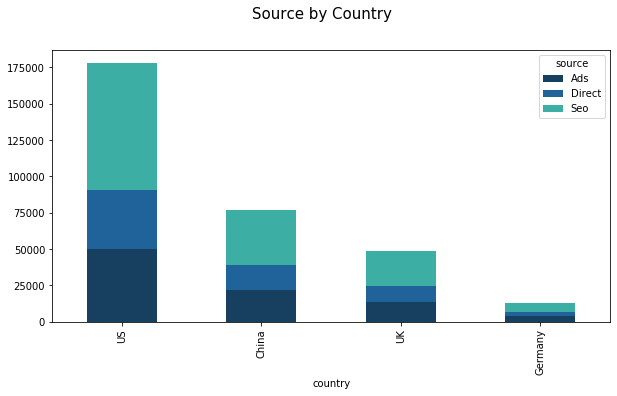

In [9]:
pivot_df = data[['country', 'source']].pivot_table(index='country', columns='source', aggfunc=len, fill_value=0)
pivot_df.loc[['US','China', 'UK', 'Germany'],:].plot.bar(stacked=True, color = colors, figsize=(10,5))
plt.suptitle('Source by Country',fontsize=15,y=1)

In [10]:
pivot_df["sum"] = pivot_df.iloc[:,0] + pivot_df.iloc[:,1] + pivot_df.iloc[:,2]
pivot_df_new = pivot_df.iloc[:,0:3].div(pivot_df["sum"], axis=0)
pivot_df_new

source,Ads,Direct,Seo
country,,,
China,0.281468,0.227971,0.490562
Germany,0.287990,0.219363,0.492647
UK,0.279009,0.229742,0.491249
US,0.280198,0.230005,0.489797


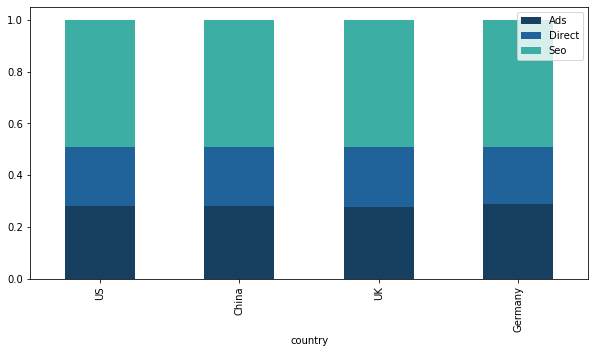

In [11]:
pivot_df_new.loc[['US','China', 'UK', 'Germany'],:].plot.bar(stacked=True, color = colors, figsize=(10,5))
plt.legend(loc='upper right')

Text(0.5, 1, 'Source by Country')

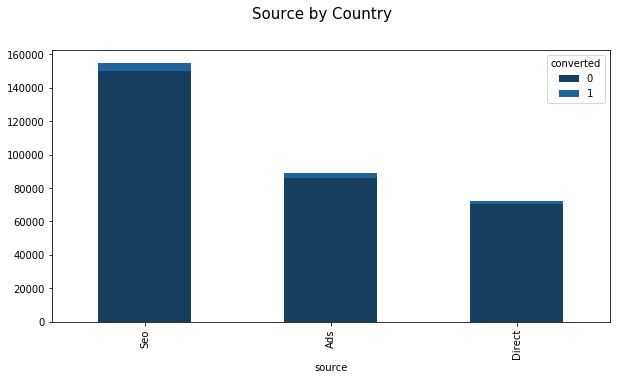

In [12]:
pivot_df = data[['source','converted']].pivot_table(index='source', columns='converted', aggfunc=len, fill_value=0)
pivot_df.loc[['Seo','Ads','Direct'],:].plot.bar(stacked=True, color = colors, figsize=(10,5))
plt.suptitle('Source by Country',fontsize=15,y=1)

In [13]:
pivot_df["sum"] = pivot_df.iloc[:,0] + pivot_df.iloc[:,1]
pivot_df_new = pivot_df.iloc[:,0:2].div(pivot_df["sum"], axis=0)
pivot_df_new

converted,0,1
source,,
Ads,0.965517,0.034483
Direct,0.971831,0.028169
Seo,0.967105,0.032895


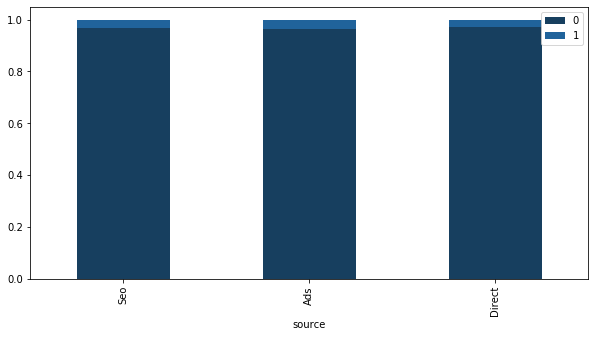

In [14]:
pivot_df_new.loc[['Seo','Ads','Direct'],:].plot.bar(stacked=True, color = colors, figsize=(10,5))
plt.legend(loc='upper right')

#### Correlation Matrix

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text xticklabel objects>)

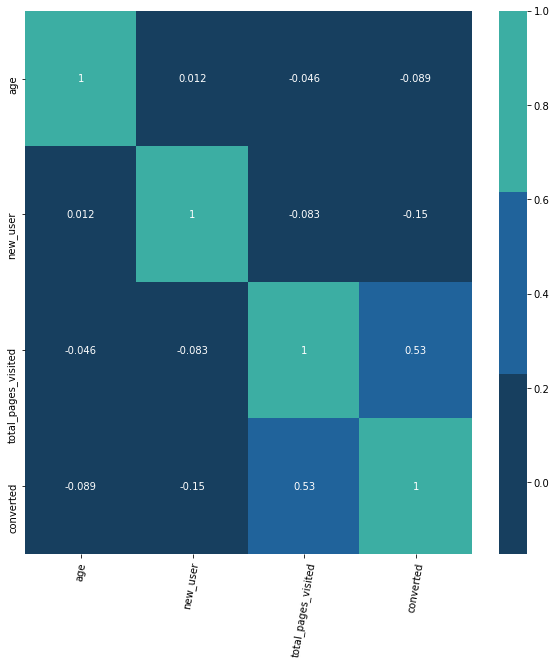

In [15]:
plt.subplots(figsize = (10,10))
corr_plot = data.corr()
sns.heatmap(corr_plot,cmap = colors, annot = True, xticklabels = True, yticklabels = True)
plt.xticks(rotation = 80)

### Label Encoding

In [16]:
label_encoder = LabelEncoder()
data['country'] = label_encoder.fit_transform(data['country'])
data['source'] = label_encoder.fit_transform(data['source'])

In [17]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,0,1,0
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


### Prediction Model

#### Under sample - balancing the cases of target variable

Due to the imbalanced data structure which will influence the prediction result, I use under sample to reshape the data.

In [18]:
# under sampling - generate sample of class 0 types matching number of class 1 types
count0, count1 = data.converted.value_counts()
converted = data[data.converted==1]
non_converted = data[data.converted==0]

under0 = non_converted.sample(count1)
model_dta = pd.concat([under0,converted],axis=0)
model_dta.head()

,country,age,new_user,source,total_pages_visited,converted
275979,3,44,1,1,3,0
175705,2,35,0,2,6,0
6787,3,34,1,2,3,0
90873,3,18,0,2,2,0
178886,0,33,1,1,6,0


In [19]:
model_dta.shape

(20400, 6)

(array([10200.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10200.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

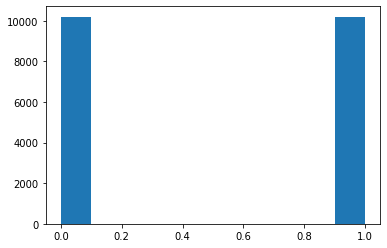

In [20]:
plt.hist(model_dta.converted)

#### Train the decision tree model and get the performance evaluation 

In [21]:
X = model_dta.iloc[:,:5]
y = model_dta.converted.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=22)

dtree = DecisionTreeClassifier(max_depth=4, random_state=22)
dtree.fit(X_train, y_train)
yhat = dtree.predict(X_test)

#using accuracy as our performance metric
score = dtree.score(X_test, y_test)

print('--- Accuracy ---')
print(round(score,2))

print('- Performance -')
print(classification_report(y_test, yhat))

--- Accuracy ---
0.93
- Performance -
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2043
           1       0.95      0.91      0.93      2037

    accuracy                           0.93      4080
   macro avg       0.94      0.93      0.93      4080
weighted avg       0.94      0.93      0.93      4080



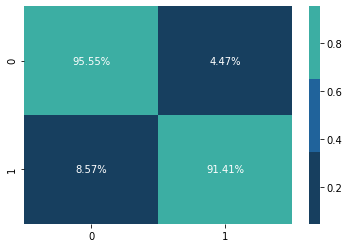

In [22]:
cf_matrix = confusion_matrix(y_test, yhat) 
sns.heatmap(cf_matrix/np.sum(cf_matrix, axis=1), annot=True, fmt='.2%', cmap = colors)

#### Feature importance

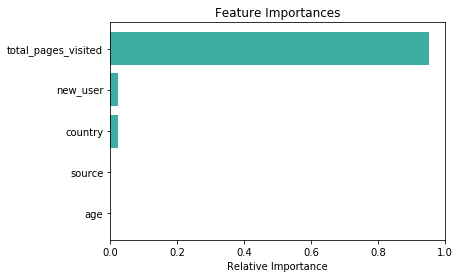

In [23]:
features = data.columns[:5]
importances = dtree.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#3CAEA3', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Tree Plot

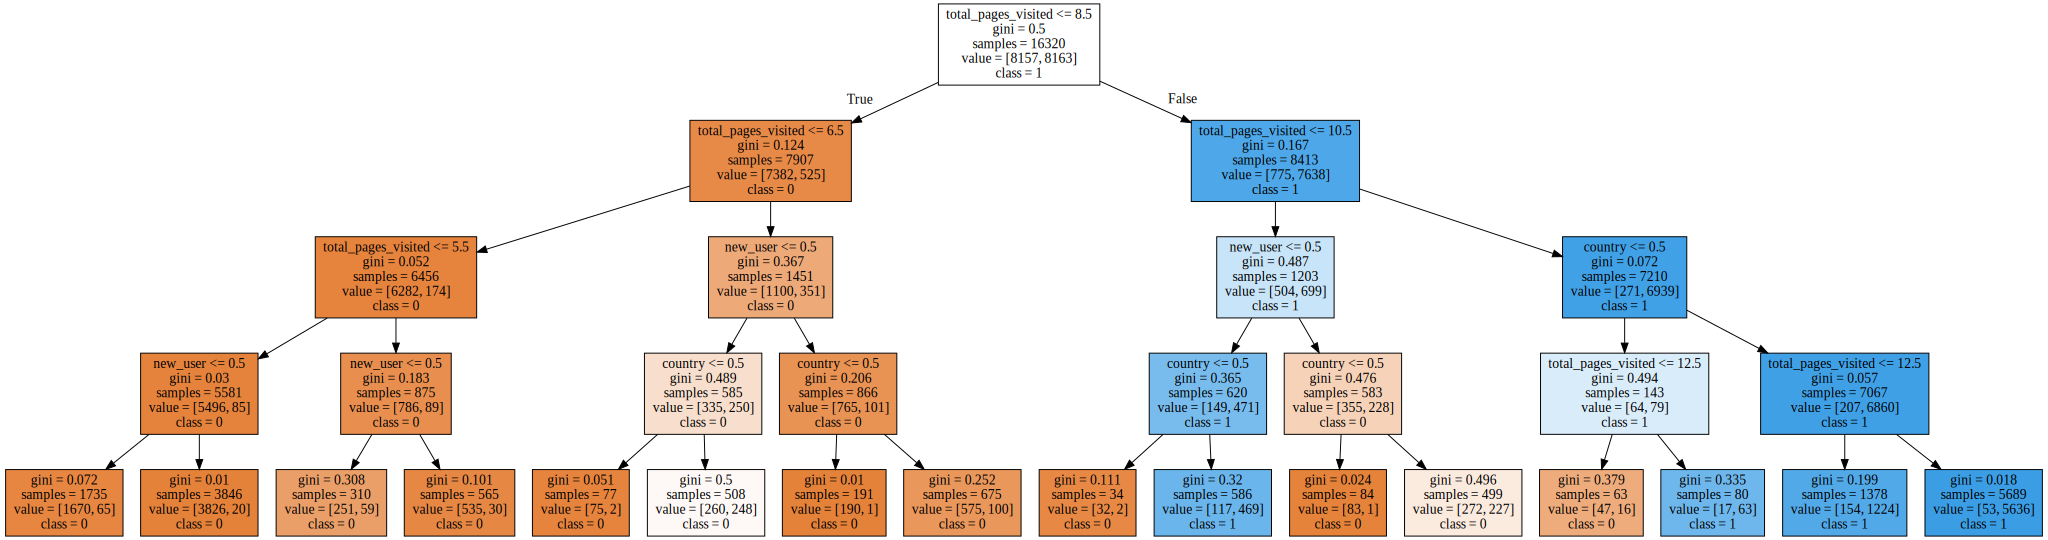

In [24]:
# DOT data
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names=features,  
                                class_names=['0','1'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

Main Take Away:

1. The accuracy of model is 95% with comparatively low misclassified propability.  94% of shoppers that did not convert, and 95% of shoppers that did convert were correctly classified.
2. The most important feature is total page visited, followed by new user and country. Source and age are not important features for the prediction model.

### Get Predicted Convertion Rate For Each User

In [25]:
pred = dtree.predict_proba(data.iloc[:,:5])[:,1]
data_final = data.copy()
data_final['predicted_conversion_rate'] = pred
data_final['predicted_conversion_rate'] = round(data_final['predicted_conversion_rate'],3)
data_final.head()

,country,age,new_user,source,total_pages_visited,converted,predicted_conversion_rate
0,2,25,1,0,1,0,0.005
1,3,23,1,2,5,0,0.005
2,3,28,1,2,4,0,0.005
3,0,39,1,2,5,0,0.005
4,3,30,1,2,6,0,0.053


### Recommendation

#### Demographic Features of Converted Users 

In [30]:
converted_user = data_origin[data_origin.converted == 1]
converted_user.head()

,country,age,new_user,source,total_pages_visited,converted
54,US,25,1,Direct,18,1
72,US,33,0,Seo,15,1
87,US,18,0,Direct,19,1
130,US,17,0,Ads,19,1
182,US,19,0,Ads,9,1


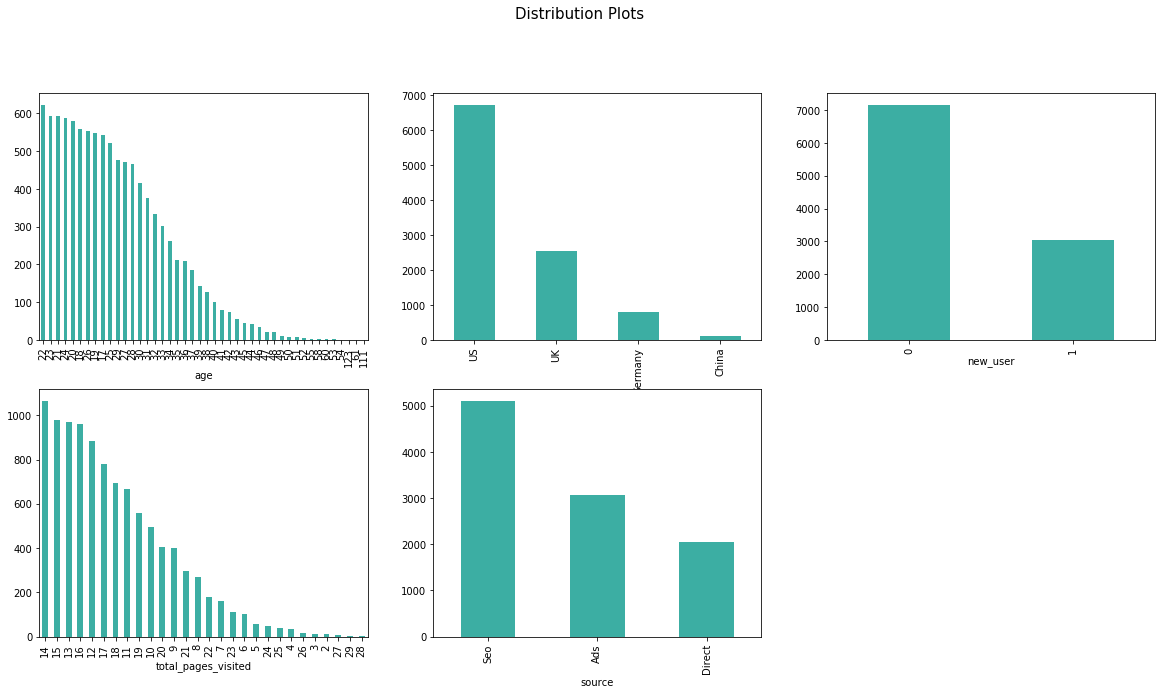

In [40]:
plt.subplots(figsize=(20,10))
i = 1
for y in ['age','country','new_user','total_pages_visited','source']:
    plt.subplot(2, 3, i)
    converted_user[y].value_counts().plot('bar', color = '#3CAEA3')
    plt.xlabel(y)
    i = i + 1
plt.suptitle('Distribution Plots',fontsize=15,y=1)
plt.show()

#### Customer Persona Based On Tree Plot and Demographic Features Above

1. Young shopper under 40.
2. Total pages visited are more than 8.5.
3. Most likely to be a returning user.
4. Coming from the U.S.

#### Recommendations

1. Personalized marketing offers: 

   For people with high probability but don't purchase (converted = 0), providing personalized marketing offers such as follow up email, personalized messages, etc. to attract them to complete the conversion. 
   
   The marketing team can set their own threshold of the predicted conversion rate to decide the size of group that we want to provide the personalized offers.
   
   Futhermore, the users with higher total pages visited are supposed to have a higher probability to become converted shoppers. So it is recommended that once we target the users who visit more than 8 pages but don't purchase, we can try to follow up with them to encourage further purchases.
   

2. Identify the problems and develop the market in China:

   Chinese users are the second largest user group but with the least converted users. Chinese market is promising but there should be some problems with the website, purchase experience, or something else, which we can't convert the large pool of Chinese users successfully.
   
   I recommend to identify the core problems in the Chinese market, especially the Chinese user experiences in purchase and payment, to find the reasons why many Chinese users view the website but don't purchase.